In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from brian2 import *

# the following dictionary defines style parameters to resemble the style of the figures in the paper, however, uncommenting these 2 lines will not affect the results
my_params = {'figure.dpi' : 300, 'figure.figsize' : [3,2],'font.size':8,'font.family':'Arial','axes.spines.top': False, 'axes.spines.right': False} #adjust some of the default style parameters
plt.rcParams.update(my_params) # update the default style parameters with the style parameters defined above
#To revert to the default style parameters, uncomment the following line
# plt.rcParams.update(matplotlib.rcParamsDefault)

In [11]:
#-------------------------------------------------------------------------
# Helper functions
#-------------------------------------------------------------------------

#Defines a number of helper functions that is used to build the network or to analyse the data

def shuffled_idx(N_pre,N_post, conn_prob):
    '''
    Generates an array of pre and post-synaptic indices to connect neurons in a homogenous way, meaning that each neuron has the same number of incoming and outgoing connections 
    :param N_pre: The number of presynaptic neurons
    :param N_post: The number of postsynaptic neurons
    :param conn_prob: The connection probability (between 0 and 1) between pre and post synaptic neurons
    :return: an array with indices for both the pre and post population
    '''
    indices_pre=[]
    indices_post=[]
    for i in range (int(N_post*conn_prob+0.5)):
        indices_pre.append(np.arange(N_pre))
    for j in range (int(N_pre*conn_prob+0.5)):
        indices_post.append(np.arange(N_post))
    indices_pre = np.concatenate(indices_pre)
    indices_post = np.concatenate(indices_post)
    np.random.shuffle(indices_pre)
    np.random.shuffle(indices_post)
    if len(indices_pre) != len(indices_post):
        return print('Pre and postsynaptic indices have different lengths')
    elif all(indices_pre==indices_post):
        return print('ATTENTION, pre and post indices are the same, use a different seed to shuffle the indices')
    else:
        return indices_pre, indices_post
    
def raster_interval_idx(start_time, stop_time, spike_times, select='idx'):
    '''function: Truncated spiketrains for defined intervals
    :param start_time: float for the start of the interval in seconds
    :param stop_time: float for the end of the interval in seconds
    :param spike_times: list with the unitless spiketimes in seconds
    :select: either 'spikes' or 'idx', when spikes then it gives the spiketrain and when idx then it gives the start_idx and stop_idx
    :return: truncated spiketrain when 'spikes' and start or stop idx when 'idx'
    '''
        
    if len(spike_times)==0 or start_time > spike_times[-1] or stop_time < spike_times[0]:
        start_id='no_spikes'
        stop_id = 'no_spikes'        
    else:
        start_id = next(x[0] for x in enumerate(spike_times) if x[1] >= start_time)
        if stop_time > spike_times[-1]:
            stop_id=len(spike_times)
        else:
            stop_id = next(x[0] for x in enumerate(spike_times) if x[1] >= stop_time)
        
    if select == 'spikes':
        if start_id=='no_spikes':
            return []
        else:
            return spike_times[start_id:stop_id]
    if select == 'idx':
        return start_id, stop_id
    
def spike_times_unitless(spike_times):
    '''function: Function that removes the unit of seconds from
    :param spike_times: dictionary returned by brian2 with spiketimes in seconds
    :return: Dictionary with spike times without units'''
    
    spike_times_unitless = {}
    for k, v in spike_times.items():  # items method returns a list of tuple pairs
        spike_times_unitless[k] = v / second  # The for loop removes the seconds from the spiketrains
    return spike_times_unitless

In [12]:
#-------------------------------------------------------------------------
# Define the neuron models
#-------------------------------------------------------------------------

#Define neuron models to simulate different neuron populations with the Brian2 simulator. Unless otherwise stated, 
#the neuron models are identical to the ones defined in Naud et al. 2018 (Sparse bursts optimize information transmission in a multiplexed neural code,PNAS)

def pyramidal_model(N):
    '''
    Define a two-compartmental neuron model of L5 PCs.
    The neurons are modeled in the Brian2 simulater using two separate compartments (soma and dend) with coupled variables.
    Implementing two separate compartments allows monitoring somatic and burst activity online and simultaneously.
    :param N: Number of neurons in the network
    :return: The somatic and dendritic compartment of L5 PCs
    '''
    
    # Differential equations that define the dynamics of the somatic compartment of L5 PCs
    soma_eqs = '''
    du_s/dt = - (u_s - EL)/tau_s + (g_s * m  + I_s + w_s) / C_s: volt (unless refractory) # Somatic voltage equation
    dw_s/dt = - w_s / tau_w_s : amp # Somatic adapatation variable
    
    I_s = I_s_ext * pamp - g_gaba + g_ampa + I_s_bg: amp # The total somatic input current
    dI_s_bg/dt = (mu_s - I_s_bg) / tau_ou_s + sig_ou_s * pamp * xi_s/sqrt(tau_ou_s/2) : amp # Noisy background input equation defined by Ornstein-Uhlenbeck process 
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    
    #variables defined in the dendritic compartment but also used in the dendritic compartment
    
    start_trace_burst:1 (linked) 
    stop_trace_burst: 1 (linked) 
    u_d : volt (linked)
    m: 1 (linked)
    '''

    #equations that define the dynamics of the dendritic compartment
    # Note that start_trace_burst and stop_trace_burst don't define the neural model but allow for online detection of burst activity. Both variables decay exponentially but increase with 1 when a somatic spike is detected.
    #A burst is detected as soon as the start_trace_burst > 1.1. This occurs when a second somatic spike follows a first somatic spike within 16 ms. Start_trace_burst is reset to zero as soon as a burst is detected
    #and stays zero (in refractory mode) as long as the stop_burst_trace > 0.1. The stop_burst_trace will fall below 0.1 when there was more then 16 ms between spikes and this defines the end of a burst.
    #tau_burst is related to the burst criterium (in our case 16 ms) and is computed mathematically (see params dendrites).
    
    dend_eqs = '''
    du_d/dt = - (u_d - EL)/tau_d + (g_d * m + K + I_d + w_d) / C_d : volt # Dendritic voltage equation
    dw_d/dt = (- w_d + a_w_d * (u_d - EL)) / tau_w_d : amp #Dendritic adaptation variable
    
    I_d = I_d_ext * pamp  - g_gaba + g_ampa + I_d_bg : amp # The total dendritic input current
    
    dI_d_bg/dt = (mu_d - I_d_bg) / tau_ou_d + sig_ou_d * pamp * xi_d/sqrt(tau_ou_d/2)  : amp # Noisy background input equation defined by Ornstein-Uhlenbeck process 
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    

    dstart_trace_burst/dt=-start_trace_burst/tau_burst : 1 #Post-synaptic trace that helps to define the start of a burst
    dstop_trace_burst/dt=-stop_trace_burst/tau_burst : 1 #Post-synaptic trace that helps to define the end of a burst

    m = 1/(1 + exp(-(u_d - Ed) / Dm)) : 1 #Sigmoidal function defining the non-linearity in the dendritic compartment
    Ca_spike = 1/(1 + exp(-(u_d - Ed2) / Dm2)) : 1 #filtered voltage of the dendritic voltage to isolate the calcium spikes
    
    lastspike_soma : second (linked)
    K = (((t-lastspike_soma) > K1) * ((t-lastspike_soma)< K2)) * c_d : amp #Variable representing the back-propagating action potential. The injected current is a stepfunction with a value of 1 (* c_d) between 0.5 and 2.5 ms after a somatic spike and 0 otherwise.
    dburst_trace/dt =  -burst_trace/tau_stdp: 1 #Post-synaptic trace representing burst activity. This trace updates the inhibitory learning rule that controls burst activity 
    '''

    # Parameters somatic compartment
    params_soma = {
        'tau_s': 16.0 * msecond,
        'C_s': 370.0 * pfarad,
        'g_s': 1300.0 * pamp,
        'b_w_s': -200 * pamp,
        'tau_w_s': 100.0 * msecond,
        'EL': -0.07 * volt,

        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'mu_s': 0 * pamp,
        'tau_ou_s': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }
    
    # Define the somatic compartment
    soma = NeuronGroup(N_PC, model=soma_eqs, threshold='u_s> -0.05 * volt',
                       reset='''
                             w_s += b_w_s
                             u_s = EL
                             start_trace_burst += 1
                             stop_trace_burst = 1''',
                       refractory= 3 * msecond, namespace=params_soma, method='euler', dt = 0.1 * msecond)

    soma.u_s = 'EL + rand() * 0.01 * volt'     #initialise the somatic voltage around the resting potential

    # Parameters dendritic compartment
    params_dend = {
        'tau_d': 7.0 * msecond,
        'C_d': 170.0 * pfarad,
        'g_d': 1200.0 * pamp,
        'c_d': 2600.0 * pamp,
        'tau_w_d': 30.0 * msecond,
        'a_w_d': -13 * nsiemens,
        'EL': -0.07 * volt,
        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'Ed2': -0.02 * volt,
        'Dm2': 0.00001 * volt,
        'K1': 0.499 * msecond,
        'K2': 2.501 * msecond,
        'tau_burst' : - 16 / np.log(0.1) * msecond,  #0.1 comes from the criterium under which burst_stop_trace has to fall

        'mu_d': 0 * pamp,
        'tau_ou_d': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the dendritic compartment
    dend = NeuronGroup(N, model=dend_eqs, threshold='start_trace_burst > 1.1',
                       reset='''
                       burst_trace +=1
                       start_trace_burst = 0
                       ''',
                       refractory='stop_trace_burst>0.1', namespace=params_dend, method='euler', dt = 0.1 * msecond)

    # initialise dendritic voltage
    dend.u_d = 'EL + rand() * 0.01 * volt' #initialise the dendritic voltage around the resting potential

    #link dendritic and somatic variables
    soma.u_d = linked_var(dend.u_d)
    soma.m = linked_var(dend.m)
    dend.lastspike_soma = linked_var(soma.lastspike)
    soma.start_trace_burst = linked_var(dend.start_trace_burst)
    soma.stop_trace_burst = linked_var(dend.stop_trace_burst)
    return soma, dend

def SOM_interneurons(N):
    '''
    Neuron model of somatostatin positive interneurons (SOM) as defined in Naud et al. (2018).
    :param N: Number of SOM interneurons in the network
    :return: SOM interneuron population
    '''
    
    inh_eqs = '''
    du_i/dt = - (u_i - EL)/tau_SOM + (I_inh + w_i) / C_SOM: volt (unless refractory) # Voltage equation of SOMs
    dw_i/dt = - w_i / tau_w_SOM : amp # Adaptation variable of SOM interneurons

    I_inh = I_SOM_ext * pamp + g_ampa  - g_gaba + I_bg_SOM: amp # The total input current to the SOMs
    
    dI_bg_SOM/dt = (mu_SOM - I_bg_SOM) / tau_ou_SOM + sig_ou_SOM * pamp * xi/sqrt(tau_ou_SOM/2.) : amp #Noisy background input
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    '''

    params_SOM = {
        'EL': -0.07 * volt,
        'tau_SOM': 20 * msecond,
        'C_SOM': 100.0 * pfarad,
        'b_w_SOM': -150.0 * pamp,
        'tau_w_SOM': 100 * msecond,

        'mu_SOM': 0 * pamp,
        'tau_ou_SOM': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the inhibitory population
    inh = NeuronGroup(N, model=inh_eqs, threshold='u_i> -0.05 * volt',
                      reset='''
                            u_i = EL
                            w_i += b_w_SOM
                            ''',
                      refractory=3*msecond,
                      namespace=params_SOM, method='euler', dt = 0.1 * msecond)

    inh.u_i = 'EL + rand() * 0.01 * volt' #initialise the voltage around the resting potential

    return inh

def PV_interneurons(N):
    '''
    Neuron model of Parvalbumin positive interneurons (PV) as defined in Naud et al. (2018). 
    :param N: Number of PV interneurons in the network
    :return: PV interneuron population
    '''
    
    inh_eqs = '''
    du_i/dt = - (u_i - EL)/tau_PV + (I_inh) / C_PV: volt (unless refractory) # Voltage equation of PVs

    I_inh = I_PV_ext * pamp + g_ampa  - g_gaba + I_bg_PV: amp #The total input current to the PVs

    dI_bg_PV/dt = (mu_PV - I_bg_PV) / tau_ou_PV + sig_ou_PV * pamp * xi/sqrt(tau_ou_PV/2.) : amp #Noisy background input
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    '''

    params_PV = {
        'tau_PV': 10 * msecond,
        'C_PV': 100.0 * pfarad,
        'EL': -0.07 * volt,


        'mu_PV': 0 * pamp,
        'tau_ou_PV': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
    }

    # Define the inhibitory population
    inh = NeuronGroup(N, model=inh_eqs, threshold='u_i> -0.05 * volt',
                      reset='''
                            u_i = EL
                            ''',
                      refractory= 3 * msecond,
                      namespace=params_PV, method='euler', dt=0.1 * msecond)

    inh.u_i = 'EL + rand() * 0.01 * volt'  # initialise the voltage around the resting potential

    return inh

#-------------------------------------------------------------------------
# Define the synapse models
#-------------------------------------------------------------------------

def inh_plast_pre_post(pre, post, target, conn_p, weight, eta):
    '''
    Function implementing inhibitory plasticity rule where the plasticity is dependent on the pre and post-synaptic activity.
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param target: target value to set the burst and/or burst rate
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :param eta: learning rate
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta,
            'target':target
                       }

    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               dApre/dt = -Apre/tau_stdp : 1 (event-driven)
                               dApost/dt = -Apost/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                                     Apre += 1.
                                     w = clip(w+eta*(Apost-target), 0, max_weight)
                                     g_gaba += w * pamp''',
                               on_post='''
                                     Apost += 1.
                                     w = clip(w+eta*Apre, 0, max_weight)
                                     ''', namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p) # Generates the indices of pre and post populations so that the connections are homogenous
    pre_to_post.connect(i=pre_idx, j=post_idx) #Connects the populations
    
    pre_to_post.w = weight # Initialisation of the connection weights

    return pre_to_post

### In this section we explore how inhibitory plasticity rules can control the burst rate and firing rate simulatenously

In [13]:
start_scope() #
simulation_time = 50
tau_stdp = 20 * msecond

#-------------------------------------------------------------------------
# Create the neuronal populations
#-------------------------------------------------------------------------

#Define the L5 Pyramidal neurons
N_PC = 1600 #Number of L5 PC cells
I_s_ext_val = [700,1100] #Low and high external somatic input current in pA
I_s_ext = I_s_ext_val[0] # Low somatic input current, Brian2 needs to have an explicit variable I_s_ext when building the L5 PC model
I_d_ext = 650 #External dendritic input current in pA 
sig_ou_s = 100  #Noise on the external somatic input current in pA
sig_ou_d = 100  #Noise on the external dendritic input current in pA
soma,dend= pyramidal_model(N_PC) #Function that defines the L5 pyramidal model 
dend_spikemonitor = SpikeMonitor(dend) # brian2 monitor recording spikes from a Neuron group
soma_rate = PopulationRateMonitor(soma) # brian2 monitor recording time-varying firing rate of a population of neurons
dend_rate = PopulationRateMonitor(dend) # brian2 monitor recording time-varying firing rate of a population of neurons

#Define the SOM interneurons
N_SOM = 400 # Number of SOM neurons
I_SOM_ext = 90 #External input current to the SOM population in pA 
sig_ou_SOM = 400 #Noise on the external input current of SOM population in pA
SOM = SOM_interneurons(N_SOM) #Function that defines the SOM neuronal model
# SOM_rate = PopulationRateMonitor(SOM)  # brian2 monitor recording time-varying firing rate of a population of neurons

#Define the PV interneurons
N_PV = 400 # Number of PV neurons
I_PV_ext = -45 #External input current to the PV population in pA 
sig_ou_PV = 400 #Noise on the external input current of PV population in pA
PV = PV_interneurons(N_PV) #Function that defines the PV neuronal model
# PV_rate = PopulationRateMonitor(PV)

#-------------------------------------------------------------------------
# Connect the interneurons with the PCs
#-------------------------------------------------------------------------
#The learning rate eta was increased to reduce the simulation time without qualitative change of results

#Connect SOMs with the dendrites
burst_target_rate = 1 * Hz
burst_target =  2 *burst_target_rate * tau_stdp # burst rate in Hz
SOM_dend = inh_plast_pre_post(SOM, dend, target  = burst_target ,  conn_p = 1, weight = 10, eta = 1) #eta in paper is 0.1
var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=100*msecond)

#Connect PVs with somata
firing_target_rate = 10 * Hz
firing_target =  2 * firing_target_rate * tau_stdp # firing rate in Hz
PV_soma = inh_plast_pre_post(PV, soma, target = firing_target, conn_p = 1, weight = 10, eta = 0.1) #eta in paper is 0.01
var_PV_soma=StateMonitor(PV_soma, ('w'),record=np.arange(25),dt=100*msecond)

#-------------------------------------------------------------------------
#Run the simulations for strong and weak input currents
#-------------------------------------------------------------------------

store()
burst_rate = {}
firing_rate = {}
w_SOM_dend = {}
w_PV_soma = {}
for j in range (len(I_s_ext_val)):
    print('-> {} pA of external somatic input'.format(I_s_ext_val[j]))
    restore()
    I_s_ext = I_s_ext_val[j]
    run((simulation_time)*second,report='stdout',profile=True)
    burst_rate[j] = dend_rate.smooth_rate(window='flat', width = 1000 * ms)/Hz
    firing_rate[j] = soma_rate.smooth_rate(window='flat', width = 1000 * ms)/Hz
    w_SOM_dend[j] = var_SOM_dend.w
    w_PV_soma[j] = var_PV_soma.w

-> 700 pA of external somatic input
Starting simulation at t=0. s for a duration of 50. s
1.5765999999999998 (3%) simulated in 10s, estimated 5m 7s remaining.
3.1282000000000005 (6%) simulated in 20s, estimated 5m 0s remaining.
4.5989 (9%) simulated in 30s, estimated 4m 56s remaining.
5.9739 (11%) simulated in 40s, estimated 4m 55s remaining.
7.4373000000000005 (14%) simulated in 50s, estimated 4m 46s remaining.
8.93 (17%) simulated in 1m 0s, estimated 4m 36s remaining.
10.4192 (20%) simulated in 1m 10s, estimated 4m 26s remaining.
11.9162 (23%) simulated in 1m 20s, estimated 4m 16s remaining.
13.412500000000001 (26%) simulated in 1m 30s, estimated 4m 6s remaining.
14.893600000000001 (29%) simulated in 1m 40s, estimated 3m 56s remaining.
16.4003 (32%) simulated in 1m 50s, estimated 3m 45s remaining.
17.9323 (35%) simulated in 2m 0s, estimated 3m 35s remaining.
19.4581 (38%) simulated in 2m 10s, estimated 3m 24s remaining.
20.973300000000002 (41%) simulated in 2m 20s, estimated 3m 14s r

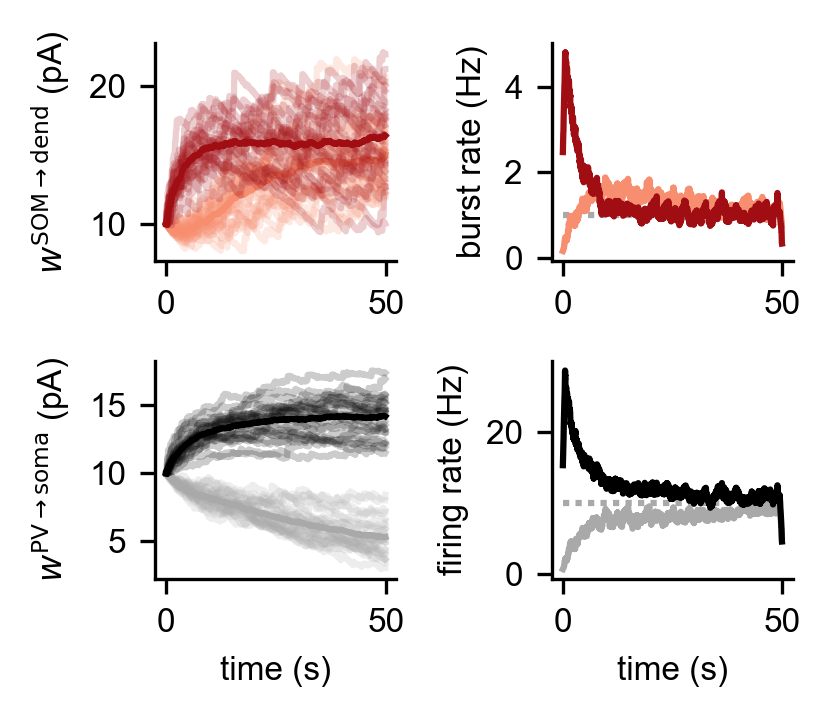

In [15]:
#-------------------------------------------------------------------------
# Plot the figure
#-------------------------------------------------------------------------

fig_rate_weights = plt.figure(figsize=(1.4 * 2, 1.2*2), dpi=300)

colors_dend = ['#F78E6F','#A00E14']
colors_soma = ['#A9A9A9','#000000']

ax_1 = fig_rate_weights.add_subplot(221)
for j in range (len(I_s_ext_val)):
    for i in range (25):
        time = np.arange(0, len(w_SOM_dend[j][i])/10, 0.1) #sampling rate of the weight values rate is 100 ms (to reduce memory needs) so the step size of the numpy array is 0.1 seconds
        plt.plot(time, w_SOM_dend[j][i],color = colors_dend[j], alpha = 0.2) #plot individual weigth traces
    average_weights = np.mean(w_SOM_dend[j], axis=0)  #plot mean weight of the recorded weights
    plt.plot(time,average_weights,color = colors_dend[j])
plt.ylabel(r'$w^{\mathrm{{SOM}}\rightarrow \mathrm{dend}}$ (pA)', fontname='Arial', fontsize=8)

ax_2 = fig_rate_weights.add_subplot(222)
for j in range (len(I_s_ext_val)):
    time = np.arange(0, len(burst_rate[j])/10000,0.0001) #sampling rate of the burst rate is 0.1 ms so the step size of the numpy array is 0.0001 seconds
    plt.plot(time,burst_rate[j],colors_dend[j])
plt.hlines(burst_target/(2*Hz*tau_stdp), 0, simulation_time, linestyles=(0, (1, 1)), color='darkgrey') # plot the target firing rate
plt.ylabel('burst rate (Hz)', fontname='Arial', fontsize=8)

ax_3 = fig_rate_weights.add_subplot(223)
for j in range (len(I_s_ext_val)):
    for i in range (25):
        time = np.arange(0, len(w_PV_soma[j][i])/10, 0.1) #sampling rate of the weight values rate is 100 ms (to reduce memory needs) so the step size of the numpy array is 0.1 seconds
        plt.plot(time, w_PV_soma[j][i],color = colors_soma[j], alpha = 0.2) #plot individual weigth traces
    average_weights = np.mean(w_PV_soma[j], axis=0) #plot mean weight of the recorded weights
    plt.plot(time,average_weights,color = colors_soma[j])
plt.ylabel(r'$w^{\mathrm{{PV}}\rightarrow \mathrm{soma}}$ (pA)', fontname='Arial', fontsize=8)
plt.xlabel('time (s)', fontname='Arial', fontsize=8)

ax_4 = fig_rate_weights.add_subplot(224)
for j in range (len(I_s_ext_val)):
    time = np.arange(0, len(burst_rate[j])/10000,0.0001)  #sampling rate of the burst rate is 0.1 ms so the step size of the numpy array is 0.0001 seconds
    plt.plot(time,firing_rate[j],colors_soma[j])
plt.hlines(firing_target/(2*Hz*tau_stdp), 0, simulation_time, linestyles=(0, (1, 1)), color='darkgrey') # plot the target burst rate
plt.ylabel('firing rate (Hz)', fontname='Arial', fontsize=8)
plt.xlabel('time (s)', fontname='Arial', fontsize=8)

plt.tight_layout()